### Gradient boosting neural network example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.preprocessing import StandardScaler
import sklearn.datasets as dts
from sklearn.metrics import mean_squared_error

from GBNN import GNEGNEClassifier, GNEGNERegressor


In [2]:
def plotModel(x,y,clase,clf,title,show_points=True):
    """
      Function for plotting the output of a model for 2D datasets
    """
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    #x_min, x_max = -2 - .2, 2 + .2
    #y_min, y_max = -2 - .2, 4 + .2
    hx = (x_max - x_min)/500.
    hy = (y_max - y_min)/500.

    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    multiclass = False
    regression = False
    if hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        if z.shape[1]==2:
            z = z[:,1]
        else:
            multiclass = True
            zz = z.copy()
            z.sort()
            z = z[:,-1]
    elif hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        #pass
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        if len(set(z)-set(clase))>0:
            regression = True

    z = z.reshape(xx.shape)
    cm = plt.cm.viridis
    cm_bright = ListedColormap(['#808080', '#FFFFFF'])
    #ax = plt.subplot(1, 1, 1)
    plt.contourf(xx, yy, z, levels=11,cmap=cm)#, alpha=.8)

    if not regression:
        if multiclass:
            for i in range(zz.shape[1]):
                z = zz[:,i] - np.max(np.delete(zz,i,axis=1),axis=1)
                z = z.reshape(xx.shape)
                plt.contour(xx, yy, z, [0.0], linewidths=[2], colors=['k'])
        else:
            plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if show_points:
        if clase is not None:
            plt.scatter(np.ravel(x), np.ravel(y), marker='o', c=np.ravel(clase), edgecolors='k')
        else:
            plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    #plt.xlabel("X")
    #plt.ylabel("Y")
    plt.title(title)


### Dataset

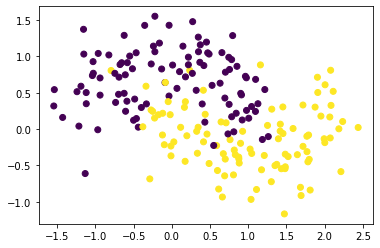

In [3]:
noise = 0.3
Xtrain, ytrain = dts.make_moons(n_samples=200,noise=noise, random_state=0)
Xtest, ytest = dts.make_moons(n_samples=1000,noise=noise, random_state=0)

plt.scatter(Xtrain[:,0], Xtrain[:,1], c=ytrain)

ss = StandardScaler()
ss.fit(Xtrain)  
Xtrain = ss.transform(Xtrain)
Xtest  = ss.transform(Xtest)


### Classification

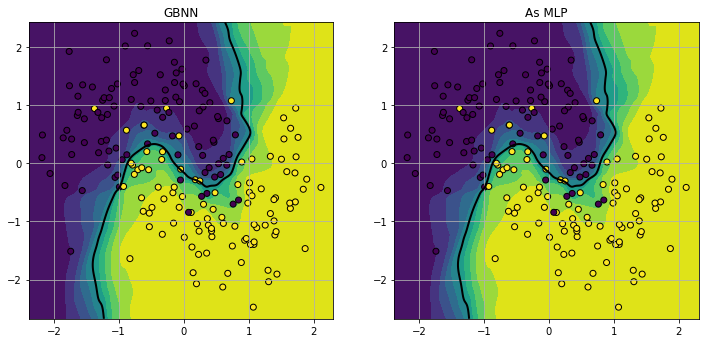

In [4]:
# Hyper-params
T    = 100
step = 1
eta  = 0.3

gne = GNEGNEClassifier(total_nn=T, num_nn_step=step, eta=eta)
gne.fit(Xtrain,ytrain)

# Using the gne model to classify
plt.figure(num=None, figsize=(12, 12))
plt.subplot(2,2,1)
plotModel(Xtrain[:,0],Xtrain[:,1],ytrain,gne,"")
plt.title("GBNN")

# Retrieve the equivalent MLPClassifier and use
nn = gne.to_NN()
plt.subplot(2,2,2)
plotModel(Xtrain[:,0],Xtrain[:,1],ytrain,nn,"")
plt.title("As MLP")

# Checking both models are the equivalent
np.testing.assert_array_almost_equal(gne.predict(Xtest), nn.predict(Xtest))
np.testing.assert_array_almost_equal(gne.predict_proba(Xtest), nn.predict_proba(Xtest))



Model accuracy =  0.909


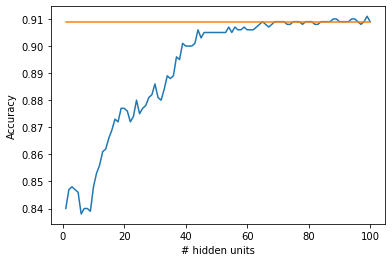

In [5]:
# Accuracy evolution with respect to the number of trained units
acc = np.mean(gne.predict(Xtest)==ytest)
plt.plot(range(1,T+1,step), gne.staged_score(Xtest,ytest),[1,100],[acc,acc])

plt.ylabel("Accuracy")
plt.xlabel("# hidden units")
print("Model accuracy = ", acc)

### Regression

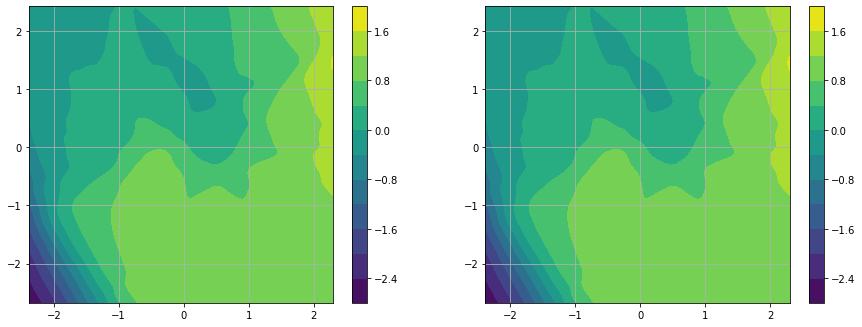

In [9]:
# Hyper-params
T    = 100
step = 1
eta  = 0.3

# Treat the moons problem as if it was a ergression task
gner = GNEGNERegressor(total_nn=T, num_nn_step=step, eta=eta)
gner.fit(Xtrain,ytrain)

# Using the gne model to do a regression
plt.figure(num=None, figsize=(15, 12))
plt.subplot(2,2,3)
plotModel(Xtrain[:,0],Xtrain[:,1],ytrain,gner,"",show_points=False)
plt.colorbar()

# Retrieve the equivalent MLPRegressor and use it
plt.subplot(2,2,4)
nnr = gner.to_NN()
plotModel(Xtrain[:,0],Xtrain[:,1],ytrain, nnr,"",show_points=False)
plt.colorbar()

# Checking both models are the equivalent
np.testing.assert_array_almost_equal(gner.predict(Xtest), nnr.predict(Xtest))


Model MSE =  0.07558499907299576


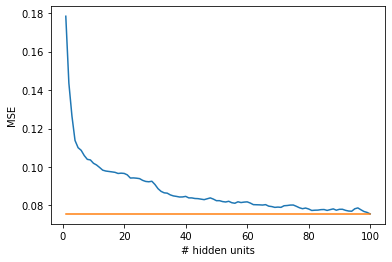

In [10]:
# MSE evolution with respect to the number of trained units
mse = mean_squared_error(gner.predict(Xtest),ytest)
plt.plot(range(1,T+1,step),gner.staged_score(Xtest,ytest),[1,100],[mse,mse])

plt.ylabel("MSE")
plt.xlabel("# hidden units")
print("Model MSE = ", mse)